In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.datasets import load_iris, load_wine
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
# Load dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

In [4]:
# Data shape
print(f"Dataset shape: {X.shape}")

Dataset shape: (178, 13)


In [6]:
# Preview features
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


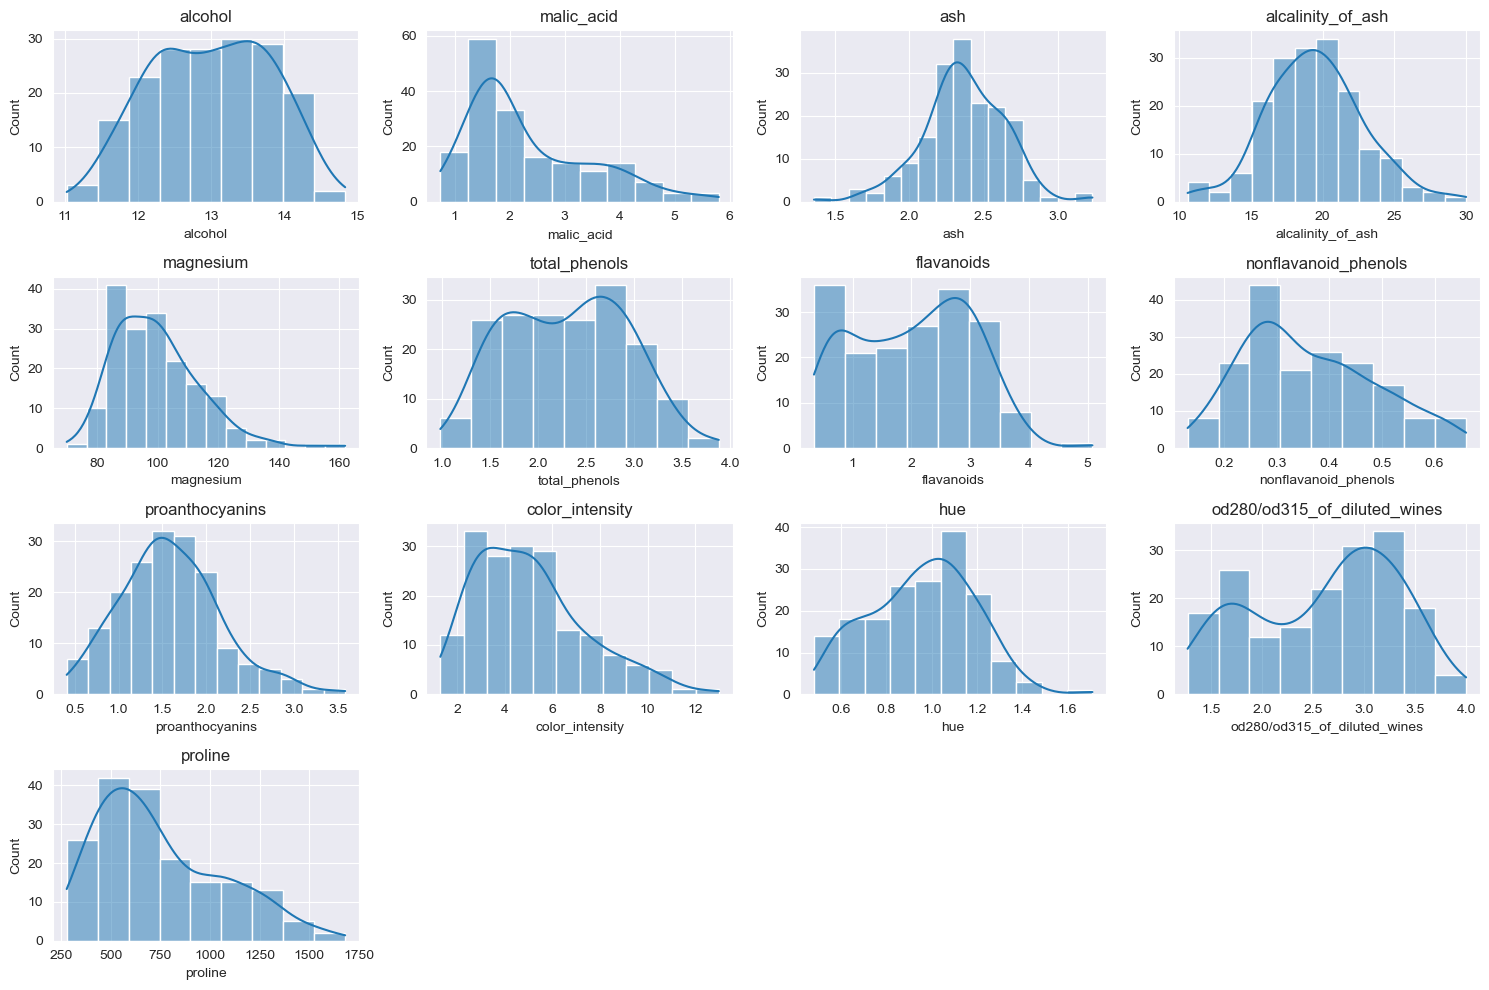

In [10]:
# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(X[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

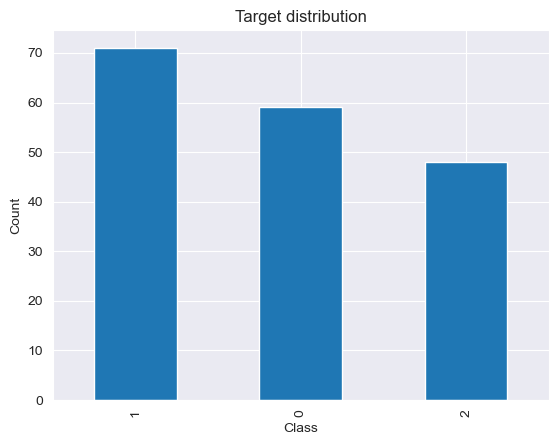

In [11]:
# Target distribution
y.value_counts().plot.bar()
plt.title('Target distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [12]:
# Check for missing values
print("Missing values:\n", X.isnull().sum())

Missing values:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


In [13]:
# Encode target if needed (already numeric in this case)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [15]:
# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

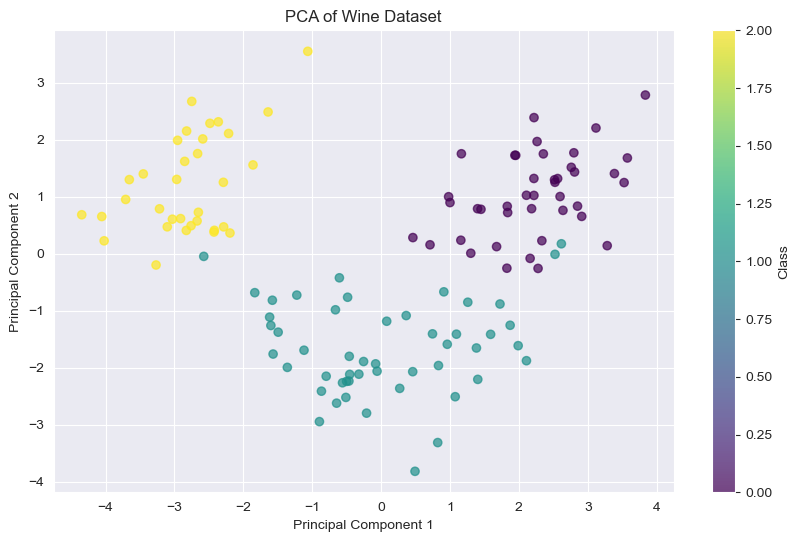

In [17]:
# Plot the reduced data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Dataset')
plt.colorbar(scatter, label='Class')
plt.show()

In [18]:
# Train initial KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [19]:
# Make predictions
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)

In [20]:
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.86      0.92        21
           2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



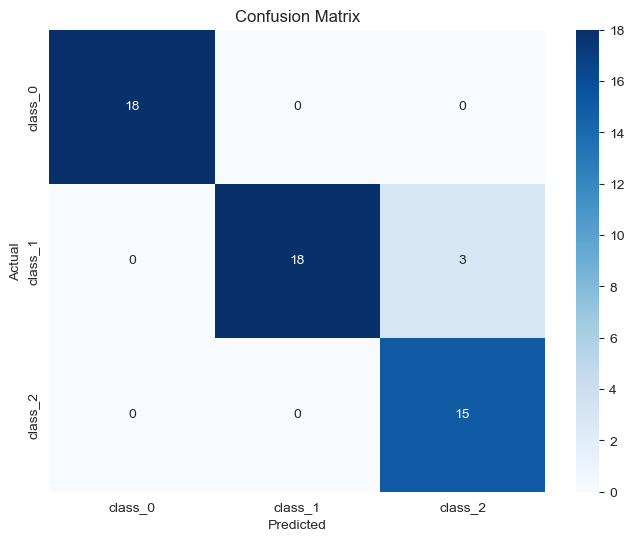

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine.target_names,
            yticklabels=wine.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# Test different k values
k_values = range(1, 30)
train_acc = []
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_acc.append(knn.score(X_train_scaled, y_train))
    test_acc.append(knn.score(X_test_scaled, y_test))

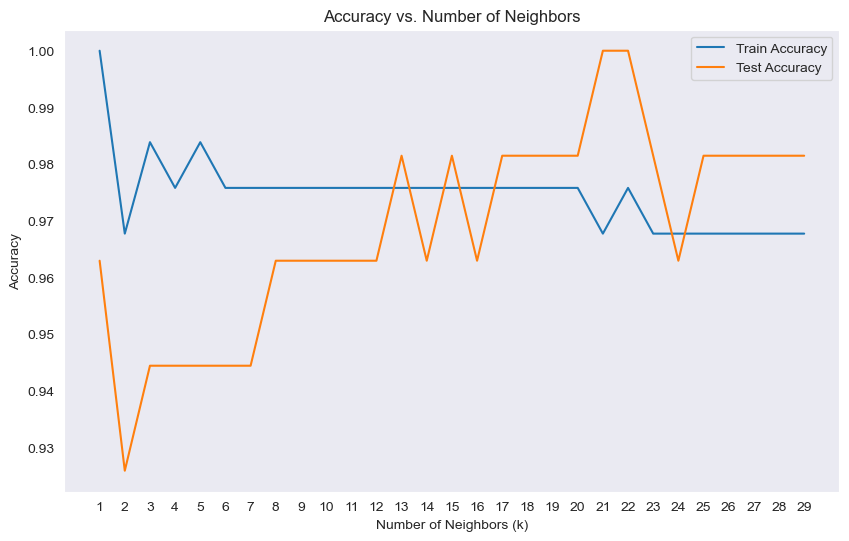

In [24]:
# Plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_acc, label='Train Accuracy')
plt.plot(k_values, test_acc, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()

In [25]:
# Find optimal k
optimal_k = k_values[np.argmax(test_acc)]
print(f"Optimal k value: {optimal_k}")

Optimal k value: 21


In [30]:
# Handle any potential missing/infinite values if they exist
# (Though the wine dataset shouldn't have any, this is good practice)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [35]:
# Create pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle potential missing values
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [36]:
# Define parameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 30, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'],
}

In [39]:
# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'  # Will raise errors instead of masking them
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [40]:
# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
Best cross-validation score: 0.98


In [41]:
# Evaluate on test set
best_knn = grid_search.best_estimator_
y_pred_tuned = best_knn.predict(X_test)
print("\nTuned Model Test Accuracy:", accuracy_score(y_test, y_pred_tuned))


Tuned Model Test Accuracy: 0.9444444444444444


In [43]:
# Reduce to 2 features for visualization
feature1, feature2 = 'alcohol', 'malic_acid'

In [44]:
# Ensure we're working with DataFrames for column access
X_train_df = pd.DataFrame(X_train, columns=wine.feature_names)
X_test_df = pd.DataFrame(X_test, columns=wine.feature_names)

In [45]:
# Select features
X_vis = X_train_df[[feature1, feature2]].values
X_vis_scaled = scaler.fit_transform(X_vis)

In [46]:
# Train KNN on 2 features
knn_vis = KNeighborsClassifier(n_neighbors=optimal_k)
knn_vis.fit(X_vis_scaled, y_train)

KNeighborsClassifier(n_neighbors=21)

In [47]:
# Create mesh grid
h = 0.02  # step size in the mesh
x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [48]:
# Predict for each point in mesh grid
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

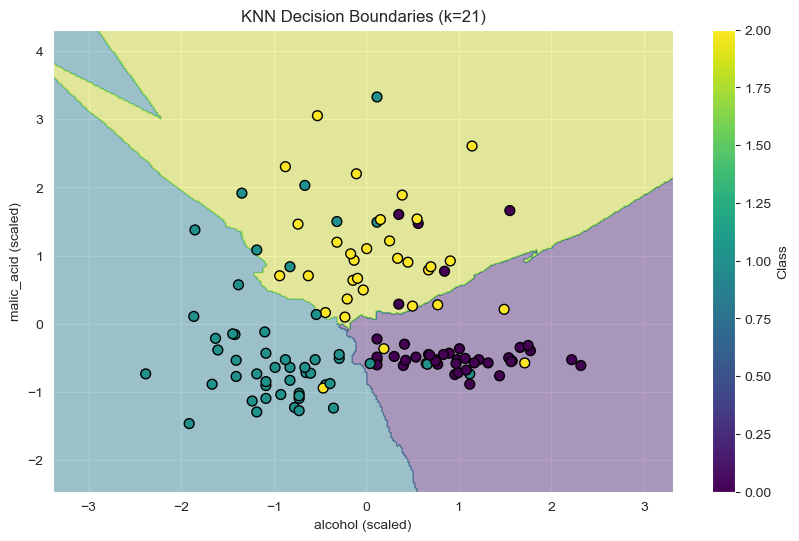

In [49]:
# Plot decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = plt.scatter(X_vis_scaled[:, 0], X_vis_scaled[:, 1], c=y_train,
                     cmap='viridis', edgecolor='k', s=50)
plt.xlabel(f"{feature1} (scaled)")
plt.ylabel(f"{feature2} (scaled)")
plt.title(f"KNN Decision Boundaries (k={optimal_k})")
plt.colorbar(scatter, label='Class')
plt.show()

In [50]:
# Compute ROC curve and ROC area for each class
n_classes = len(np.unique(y_train))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

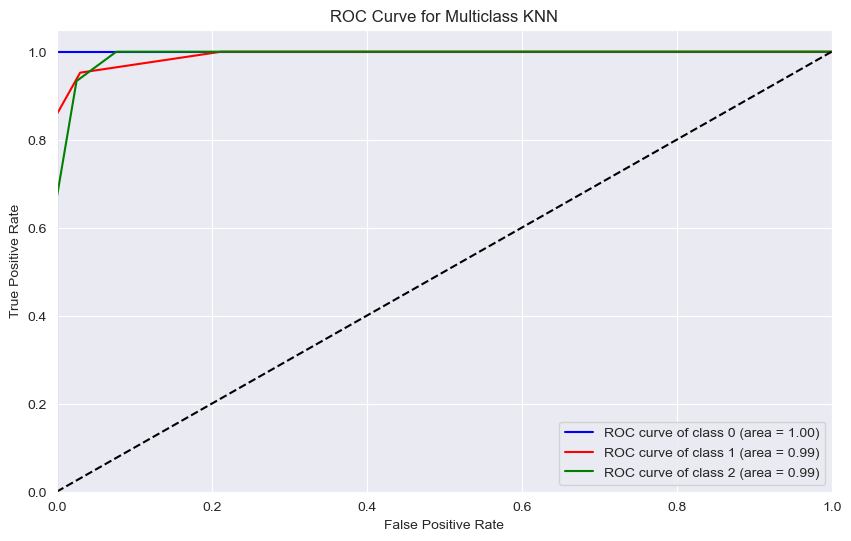

In [51]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass KNN')
plt.legend(loc="lower right")
plt.show()

In [54]:
# Although KNN doesn't provide feature importance directly, we can analyze
# how removing features affects performance

feature_importance = {}
original_score = accuracy_score(y_test, best_knn.predict(X_test))

for feature in X.columns:
    X_reduced = X.drop(feature, axis=1)
    X_train_red, X_test_red = train_test_split(
        X_reduced, test_size=0.3, random_state=42, stratify=y_encoded)

    # Scale and predict with best parameters
    X_train_red_scaled = scaler.fit_transform(X_train_red)
    X_test_red_scaled = scaler.transform(X_test_red)

    knn_red = KNeighborsClassifier(
        n_neighbors=grid_search.best_params_['knn__n_neighbors'],
        weights=grid_search.best_params_['knn__weights'],
        metric=grid_search.best_params_['knn__metric'])

    knn_red.fit(X_train_red_scaled, y_train)
    score = accuracy_score(y_test, knn_red.predict(X_test_red_scaled))
    feature_importance[feature] = original_score - score

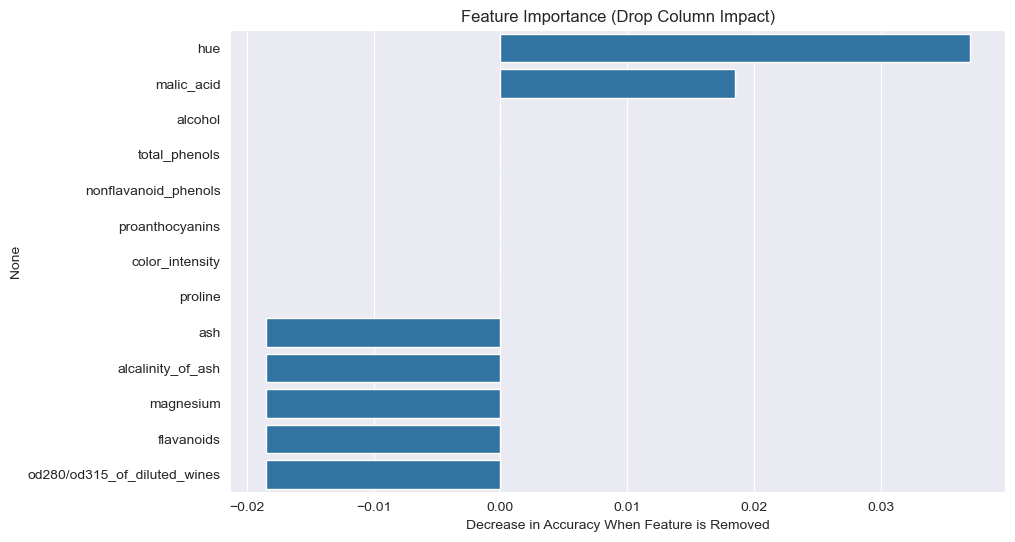

In [55]:
# Sort and plot feature importance
importance_df = pd.DataFrame.from_dict(
    feature_importance, orient='index', columns=['importance'])
importance_df.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df.importance, y=importance_df.index)
plt.title('Feature Importance (Drop Column Impact)')
plt.xlabel('Decrease in Accuracy When Feature is Removed')
plt.show()